# Efficient hyperparameter search with GridSearchCV and optuna

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

adapted from the work of Olivier Grisel and Andreas Mueller.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Most models have hyperparameters that influence how complex functions they can learn. Think the depth of a decision tree.

<img src="figures/overfitting_underfitting_cartoon.svg" width="60%">

## Hyperparameters, Over-fitting, and Under-fitting

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the depth of a decision tree or the number of trees in a gradient boosting are such hyperparameters.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of ``max_depth``:

In [2]:
import pandas as pd

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor

print('Loading data...')
# load or create your dataset
df_train = pd.read_csv('datasets/regression.train', header=None, sep='\t')
df_test = pd.read_csv('datasets/regression.test', header=None, sep='\t')

df = pd.concat([df_train, df_test], axis=0)
y = df[0].values
X = df.drop(0, axis=1).values

cv = KFold(shuffle=True, n_splits=5, random_state=42)

reg = DecisionTreeRegressor()

# for each parameter setting do cross-validation:
for max_depth in [1, 3, 5, 10, 20]:
    reg.set_params(max_depth=max_depth)
    scores = cross_val_score(reg, X, y, cv=cv, scoring="r2")
    print(f"max_depth: {max_depth}, average score: {np.mean(scores)}")

Loading data...
max_depth: 1, average score: 0.041434776747087156
max_depth: 3, average score: 0.0998374290737992
max_depth: 5, average score: 0.1165850881789547
max_depth: 10, average score: -0.12413870717269063
max_depth: 20, average score: -0.5163067490467792


There is a function in scikit-learn, called ``validation_plot`` to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

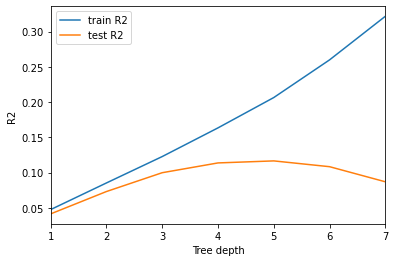

In [3]:
from sklearn.model_selection import validation_curve

max_depth = [1, 2, 3, 4, 5, 6, 7]
    
train_scores, test_scores = validation_curve(
    reg, X, y, param_name="max_depth",
    param_range=max_depth, cv=cv,
    scoring="r2"
)
plt.plot(max_depth, train_scores.mean(axis=1), label="train R2")
plt.plot(max_depth, test_scores.mean(axis=1), label="test R2")
plt.ylabel('R2')
plt.xlabel('Tree depth')
plt.xlim([1, max(max_depth)])
plt.legend(loc="best");

To automate hyperparameter search there is a built-in class in scikit-learn, ``GridSearchCV``. ``GridSearchCV`` takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

To inspect training score on the different folds, the parameter ``return_train_score`` is set to ``True``.

In [4]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': max_depth}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid,
                    cv=cv, verbose=3,
                    return_train_score=True, n_jobs=-1)

One of the great things about GridSearchCV is that it is a *meta-estimator*. It takes an estimator like `DecisionTreeRegressor` above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor.
So we can call ``fit`` on it, to train it:

In [5]:
grid.fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7]},
             return_train_score=True, verbose=3)

What ``fit`` does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination.
Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use ``predict`` or ``score``:


In [6]:
grid.predict(X)

array([0.8697479 , 0.8697479 , 0.68272425, ..., 0.61587302, 0.28220859,
       0.51453488])

In [7]:
grid.predict(X).shape

(7500,)

You can inspect the best parameters found by ``GridSearchCV`` in the ``best_params_`` attribute, and the best score in the ``best_score_`` attribute:

In [8]:
print(grid.best_score_)

0.11641424657048097


In [9]:
print(grid.best_params_)

{'max_depth': 5}


But you can investigate the performance and much more for each set of parameter values by accessing the `cv_results_` attributes. The `cv_results_` attribute is a dictionary where each key is a string and each value is array. It can therefore be used to make a pandas DataFrame.

In [10]:
type(grid.cv_results_)

dict

In [11]:
print(grid.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [12]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.034127,0.004099,0.001178,0.000097,1,{'max_depth': 1},0.037408,0.059269,0.022200,0.041881,...,0.041435,0.012077,7,0.048678,0.042985,0.052221,0.047135,0.046596,0.047523,0.003000
1,0.050431,0.006653,0.001186,0.000198,2,{'max_depth': 2},0.067777,0.108785,0.055390,0.052709,...,0.073139,0.020465,6,0.082155,0.083899,0.087353,0.082700,0.090348,0.085291,0.003108
2,0.065414,0.002333,0.001121,0.000247,3,{'max_depth': 3},0.091159,0.134029,0.097577,0.056400,...,0.099837,0.026622,4,0.122633,0.120839,0.131610,0.114817,0.123688,0.122717,0.005403
3,0.085348,0.004106,0.002099,0.001397,4,{'max_depth': 4},0.095534,0.154370,0.107212,0.067739,...,0.113711,0.031745,2,0.162374,0.164971,0.164933,0.160026,0.164627,0.163386,0.001937
4,0.110620,0.002076,0.001317,0.000607,5,{'max_depth': 5},0.110940,0.144012,0.087920,0.099055,...,0.116414,0.022217,1,0.208677,0.206199,0.206271,0.201842,0.208971,0.206392,0.002555
5,0.126927,0.001961,0.001315,0.000323,6,{'max_depth': 6},0.093229,0.144031,0.072792,0.101471,...,0.108389,0.025693,3,0.255590,0.264257,0.264411,0.251926,0.262840,0.259805,0.005101
6,0.127996,0.007274,0.001318,0.000479,7,{'max_depth': 7},0.070863,0.112422,0.058734,0.072674,...,0.084841,0.021883,5,0.316922,0.330701,0.325519,0.310431,0.324594,0.321634,0.007124


In [13]:
cv_results_tiny = cv_results[['param_max_depth', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_max_depth,mean_test_score
4,5,0.116414
3,4,0.113711
5,6,0.108389
2,3,0.099837
6,7,0.084841


There is a problem with using this score for evaluation, however. You might be making what is called a **multiple hypothesis testing error**. If you try very many parameter settings, some of them will work better just by chance, and the score that you obtained might not reflect how your model would perform on new unseen data.
Therefore, it is good to split off a separate test-set before performing grid-search. This pattern can be seen as a training-validation-test split, and is common in machine learning:

<img src="figures/grid_search_cross_validation.svg" width="70%">

We can do this very easily by splitting of some test data using ``train_test_split``, training ``GridSearchCV`` on the training set, and applying the ``score`` method to the test set:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'max_depth': max_depth}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.1111365917931505

We can also look at the parameters that were selected:

In [15]:
grid.best_params_

{'max_depth': 5}

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long.
You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

<img src="figures/train_validation_test2.svg" width="60%">

In [16]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'max_depth': max_depth}
single_split_cv = ShuffleSplit(n_splits=1, test_size=0.2)

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV 1/1] END .......................max_depth=1;, score=0.037 total time=   0.0s
[CV 1/1] END .......................max_depth=2;, score=0.069 total time=   0.0s
[CV 1/1] END .......................max_depth=3;, score=0.105 total time=   0.0s
[CV 1/1] END .......................max_depth=4;, score=0.118 total time=   0.0s
[CV 1/1] END .......................max_depth=5;, score=0.113 total time=   0.1s
[CV 1/1] END .......................max_depth=6;, score=0.117 total time=   0.1s
[CV 1/1] END .......................max_depth=7;, score=0.047 total time=   0.1s


0.11152232083900504

This is much faster, but it might result in worse hyperparameters and therefore worse results as the error estimate on left-out data will have much more variance. In other words you're more likely to be unlucky!

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Apply grid-search to find the best learning_rate and number of tree in a HistGradientBoostingRegressor.
      </li>
    </ul>
</div>

Solution is in: `solutions/03-gbdt_grid_search_cv.py`

In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor

learning_rate = [0.01, 0.05, 0.1]
max_iter = [10, 50, 100, 200]
param_grid = {
    'learning_rate': learning_rate,
    'max_iter': max_iter
}

est = HistGradientBoostingRegressor(random_state=42)
grid = GridSearchCV(est, param_grid=param_grid, cv=3)

grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))

pd.DataFrame(grid.cv_results_)[
    ['param_learning_rate', 'param_max_iter', 'mean_test_score']
].sort_values(by='mean_test_score', ascending=False)


0.22342480493503336


,param_learning_rate,param_max_iter,mean_test_score
6,0.05,100,0.228557
5,0.05,50,0.225541
3,0.01,200,0.217581
9,0.1,50,0.216391
7,0.05,200,0.214754
10,0.1,100,0.198656
11,0.1,200,0.182909
8,0.1,10,0.180884
2,0.01,100,0.180473
4,0.05,10,0.127286


## Guided hyper-optimization

Hyper-optimization of parameters was done up to now by giving some values to be tried. Usually, we could automatically generated those values (randomly or not) by using `RandomSearchCV` or `GridSearchCV`.

We could do a little be better by trying some parameters which we could consider more probable to optimize our problem depending on the previous parameters which we used before.

We will use `optuna` to do so.


URL : https://pypi.org/project/optuna/

See video : https://www.youtube.com/watch?v=J_aymk4YXhg

In [19]:
import optuna
from optuna import samplers


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 10**-5, 10**0, log=True)
    l2_regularization = trial.suggest_float('l2_regularization', 10**-5, 10**0, log=True)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_iter = trial.suggest_int('max_iter', 10, 1000)

    reg = HistGradientBoostingRegressor(
        **trial.params, random_state=42,
    )

    return np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1, scoring="r2"))

sampler = samplers.TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, direction='maximize')
optuna.logging.disable_default_handler()  # limit verbosity
study.optimize(objective, n_trials=10)

# Show best result
print(study.best_trial.params)
print(study.best_trial.value)

[I 2023-01-13 18:12:17,053] A new study created in memory with name: no-name-69c1eeb9-b2f6-4d51-b06c-56c6b0374bf6


{'max_depth': 15, 'learning_rate': 0.012269726788500331, 'l2_regularization': 0.003678673237063637, 'min_samples_leaf': 66, 'max_iter': 605}
0.23199190890180307


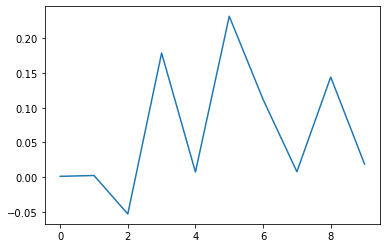

In [20]:
values = [t.value for t in study.trials]
plt.plot(values)

Text(0, 0.5, 'R2')

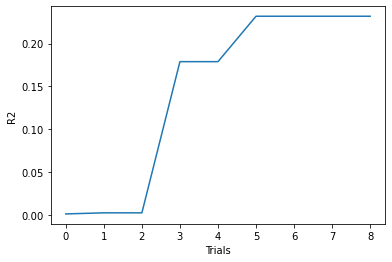

In [21]:
values = [t.value for t in study.trials]
values = [np.max(values[:k]) for k in range(1, len(values))]
plt.plot(values)
plt.xlabel('Trials')
plt.ylabel('R2')

In [22]:
reg = HistGradientBoostingRegressor(random_state=42)
reg.set_params(**study.best_trial.params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.22208064659588678

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      How would you avoid optimizing the <code>max_iter</code> parameter?
      </li>
    </ul>
</div>

Solution is in `solutions/03-gbdt_optuna.py`

{'max_depth': 22, 'learning_rate': 0.010120332166548559, 'l2_regularization': 0.10619791350957802, 'min_samples_leaf': 53}
0.22721810043694335


0.16975012828241764

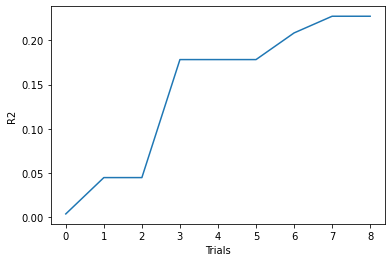

In [23]:
import optuna
from optuna import samplers


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 10**-5, 10**0, log=True)
    l2_regularization = trial.suggest_float('l2_regularization', 10**-5, 10**0, log=True)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)

    reg = HistGradientBoostingRegressor(
        **trial.params, random_state=42, max_iter=1000,
    )

    return np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1, scoring="r2"))

sampler = samplers.TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, direction='maximize')
optuna.logging.disable_default_handler()  # limit verbosity
study.optimize(objective, n_trials=10)

print(study.best_trial.params)
print(study.best_trial.value)

values = [t.value for t in study.trials]
values = [np.max(values[:k]) for k in range(1, len(values))]
plt.plot(values)
plt.xlabel('Trials')
plt.ylabel('R2')

reg = HistGradientBoostingRegressor(random_state=42)
reg.set_params(**study.best_trial.params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)


To learn more please have a look at the doc of optuna. In particular:

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize